In [1]:
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import netCDF4 as nc
from osgeo import gdal, osr, gdalconst, ogr
import pandas as pd
import xarray as xr
import cfgrib

gdal.UseExceptions()

In [6]:
nodata = -9999

def create_mask(raster_ds, vector_path, out_mask_path, disk_output=False):
    shp = vector_path
    data = raster_ds
    geo_transform = data.GetGeoTransform()
    proj = data.GetProjection()
    # source_layer = data.GetLayer()
    x_min = geo_transform[0]
    y_max = geo_transform[3]
    x_max = x_min + geo_transform[1] * data.RasterXSize
    y_min = y_max + geo_transform[5] * data.RasterYSize
    x_res = data.RasterXSize
    y_res = data.RasterYSize
    
    mb_v = ogr.Open(shp)
    mb_l = mb_v.GetLayer()
    pixel_width = geo_transform[1]
    
    drv = "GTiff" if disk_output == True else "MEM"
    out_mask_path = out_mask_path if disk_output == True else ""
    target_ds = gdal.GetDriverByName(drv).Create(out_mask_path, x_res, y_res, 1, gdal.GDT_Byte)
    # target_ds.SetGeoTransform((x_min, pixel_width, 0, y_min, 0, pixel_width))
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(proj)
    # print(target_ds)
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(nodata)
    band.FlushCache()
    
    gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE=Id"])
    mask_arr = target_ds.GetRasterBand(1).ReadAsArray().copy()

    target_ds = None
    #mask_arr = np.rot90(mask_arr,2)  # WHY??! ^^^because gt was inversed upside-down
    #mask_arr = np.flip(mask_arr,1)
    # print(mask_arr)
    
    return mask_arr

def crop_variable_to_watershed(arr, ws_path, gt, ready_mask=None, out_path=None, v=False):
    # 1) узнаем размер массива:
    s = arr.shape

    # 2) вызываем драйвер GTiff и просим его создать нам новый файл нужного размера с одним растровым каналом:
    if out_path is None:
        out_path = ""
        drv = "MEM"
    else:
        drv = "GTiff"

    driver = gdal.GetDriverByName(drv)
    rows, cols = s
    no_bands = 1
    ds = driver.Create(out_path, cols, rows, no_bands, gdal.GDT_Float32)

    # 3) записываем в файл массив измерений, значение "нет данных" и геотрансформ:
    ds.GetRasterBand(1).WriteArray(arr)
    ds.GetRasterBand(1).SetNoDataValue(nodata)
    ds.SetGeoTransform(gt)

    # 4) прикрепляем к файлу информацию о системе координат:
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # WGS84
    ds.SetProjection(srs.ExportToWkt())

    ################################################################################################

    # 5) обрезаем по водосбору:
    out_path = "runoff_%s_crop.tif" % date_str
    # crop_ds = gdal.Warp(out_path, ds, format="GTiff", cutlineDSName=ws_path, cropToCutline=True)  # does not work without cropToCutline=True
    # print(crop_ds)
    # НЕ РАБОТАЕТ ДЛЯ СЛИШКОМ МАЛЕНЬКИХ ВОДОСБОРОВ (КАК У ЛЕНЫ)

    ##################################################################################################
    # 5a) альтернативный путь для мелких водосборов: растеризуем водосбор и используем получившийся растр как маску, внутри которой считаем среднее значение:
    out_path = "runoff_mask.tif"  # will be ignored if disk_output=False
    if ready_mask is None:
        mask_arr = create_mask(ds, ws_path, out_path, disk_output=True)
    else:
        mask_arr = ready_mask

    masked_arr = np.where(mask_arr > 0, arr, nodata)
    # plt.imshow(masked_arr)
    # plt.colorbar()

    # ds.GetRasterBand(1).WriteArray(masked_arr)

    m = masked_arr[masked_arr != nodata].mean()
    if v:
        print("Mean value is %.1f mm per day" % m)

    #############################################################################################
    # 6) все операции с исходной картинкой выполнялись до этого момента в оперативной памяти
    # запись на диск будет произведена только после выполнения следующих команд:
    ds.FlushCache()
    ds = None
    
    return m, mask_arr

def fmt_date(nc_time):
    # print(nc_time, "days")
    delta = timedelta(days=float(nc_time))
    return datetime.strptime("1950-01-01 00:00:00", "%Y-%m-%d %H:%M:%S") + delta


def show_runoff(arr, date_str):
    fig, ax = plt.subplots()
    ax.set_title(date_str)
    im = ax.imshow(arr)
    fig.colorbar(im, label="mm/day", orientation="horizontal")

<xarray.Dataset>
Dimensions:     (time: 365, latitude: 11, longitude: 16)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    step        timedelta64[ns] 1 days
    surface     int64 0
  * latitude    (latitude) float64 58.55 58.45 58.35 58.25 ... 57.75 57.65 57.55
  * longitude   (longitude) float64 32.05 32.15 32.25 ... 33.35 33.45 33.55
    valid_time  (time) datetime64[ns] 1979-01-02 1979-01-03 ... 1980-01-01
Data variables:
    dis24       (time, latitude, longitude) float32 0.5469 179.9 ... 0.5156
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-08-18T13:48:13 GRIB to CDM+CF via cfgrib-0....


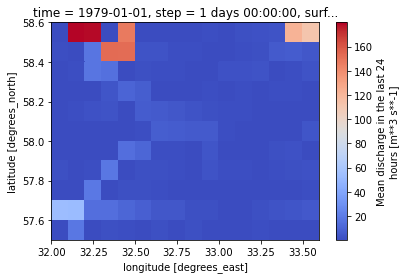

In [3]:
in_path = "/home/antonv/PycharmProjects/lena/nc/adaptor_mars_external_1660671370_331673_15565_19_7ecb9c82_3a51_43a3.grib"
# print(xr.__version__)

a = xr.load_dataset(in_path, engine="cfgrib")

print(a)
a.dis24[0].plot(cmap=plt.cm.coolwarm)

In [15]:
ws_path = "/home/antonv/PycharmProjects/lena/nc/ws/fix_Lychkovo_g.geojson"

mask = None

# 1) let's create a geotransform first:
"""
GDAL GeoTransform:
GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
GT(1) w-e pixel resolution / pixel width.
GT(2) row rotation (typically zero).
GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
GT(4) column rotation (typically zero).
GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
"""
lon_res = a.longitude.values[1] - a.longitude.values[0]
lat_res = a.latitude.values[1] - a.latitude.values[0]
lon_res = round(lon_res, 6)
lat_res = round(lat_res, 6)

xul = a.longitude.values[0]
yul = a.latitude.values[-1]
xul = round(xul, 6)
yul = round(yul, 6)
gt = [xul, lon_res, 0, yul, 0, -lat_res]  # GeoTransform готов

# 2) the rest:
mean_list = []
date_list = []

l = len(a.dis24)  # should be 365
for i in range(0, l):
    arr = a.dis24[i]
    arr = np.array(arr)
    
    arr = np.rot90(arr, 2)  # WHY??!
    arr = np.flip(arr, 1)
    # print(arr.mean())
    
    date_str = a.time.values[i]
    # print(date_str)
    out_path = "daily_runoff_%s.tif" % date_str
    
    mean, mask = crop_variable_to_watershed(arr, ws_path, gt, ready_mask=mask, out_path=None)
    
    mean_list.append(mean)
    date_list.append(date_str)

ws_name = os.path.basename(os.path.splitext(ws_path)[0])  

df = pd.DataFrame({"date": date_list, "mean_runoff": mean_list})
df.to_csv("grib_runoff_%s.csv" % ws_name, index=False)